# Recommendations with IBM

For this project, the task is to analyze the interactions that users have with articles on the IBM Watson Studio platform, and make recommendations to them about new articles that they might like. Below is an example of what the dashboard could look like displaying articles on the IBM Watson Platform.

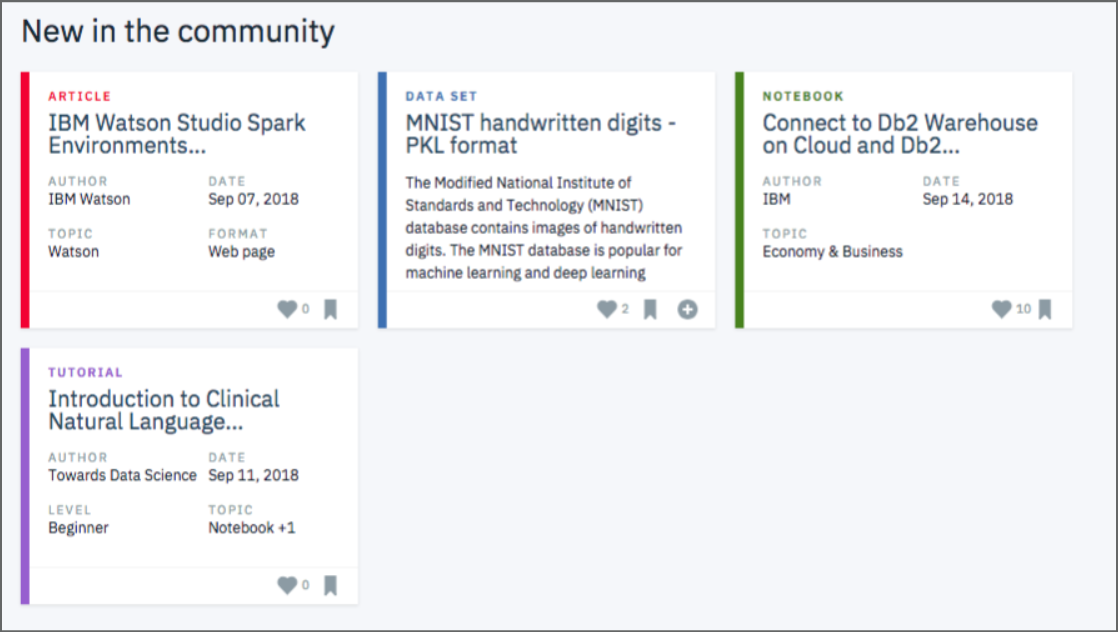

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>
V. [Extras & Concluding](#conclusions)

Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Following are some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  A visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
user_interaction = df['email'].value_counts()
print("Descriptive Statistics of user interection with articles \n")
print(user_interaction.describe())

Descriptive Statistics of user interection with articles 

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: email, dtype: float64


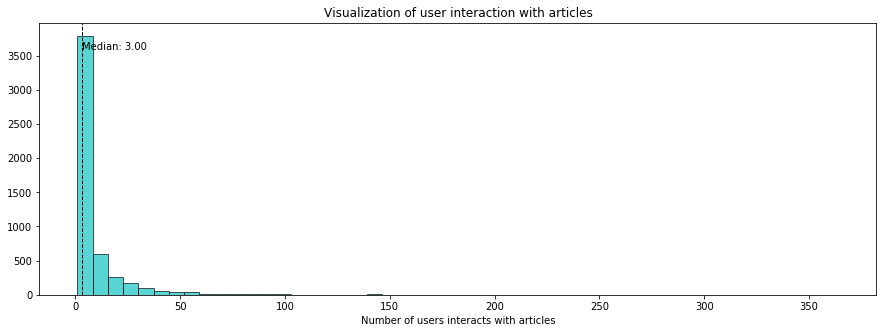

In [4]:
plt.figure(figsize=(15,5))
plt.hist(user_interaction, bins=50, color='c', edgecolor='k', alpha=0.65)
plt.axvline(user_interaction.median(), color='k', linestyle='dashed', linewidth=1)

_, max_ = plt.ylim()
plt.text(user_interaction.median() + user_interaction.median()/10, 
         max_ - max_/10, 
         'Median: {:.2f}'.format(user_interaction.median()))
plt.title("Visualization of user interaction with articles")
plt.xlabel("Number of users interacts with articles")
plt.show()

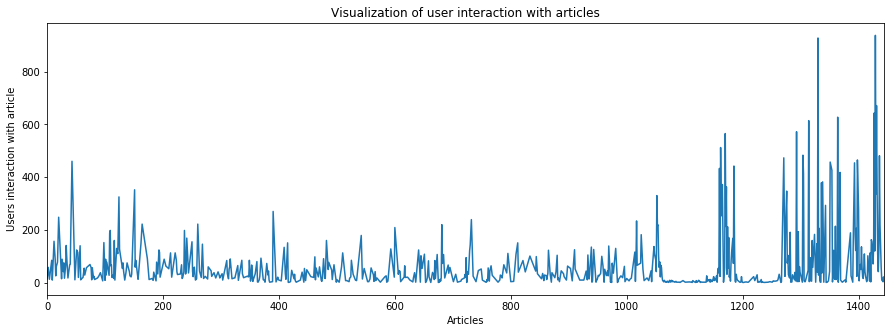

In [5]:
plt.figure(figsize=(15,5))
df.groupby(['article_id']).count()['email'].plot()
plt.title("Visualization of user interaction with articles")
plt.xlabel("Articles")
plt.ylabel("Users interaction with article")
plt.show()

In [6]:
median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [7]:
# Find and explore duplicate articles
df_content.loc[df_content['article_id'].duplicated()]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [8]:
# Remove any rows that have the same article_id - only keep the first
df_content['article_id'].drop_duplicates(keep='first', inplace=True)

`3.` Following are some questions:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [9]:
print("There are {} unique articles that have at least one interaction".format(df['article_id'].nunique()))
print("There are {} unique articles on the IBM platform".format(df_content['article_id'].shape[0]))
print("There are {} unique users".format(df['email'].nunique()))
print("There are {} user-article interactions".format(df.shape[0]))


There are 714 unique articles that have at least one interaction
There are 1051 unique articles on the IBM platform
There are 5148 unique users
There are 45993 user-article interactions


In [10]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` What about the most viewed **article_id**, as well as how often it was viewed.  

In [11]:
most_viewed_articles = df.groupby('article_id')['email'].count().sort_values(ascending=False)
most_viewed_articles.iloc[:5]

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: email, dtype: int64

In [12]:
most_viewed_article_id = '1429.0'# The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

The `email_mapper` function is deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [2]:
# Map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded


df.head()

In [3]:
sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

As we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Following function return the **n** top articles ordered with most interactions as the top.

In [15]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''

    top_articles = list(df['title'].value_counts().sort_values(ascending=False).iloc[:n].index)
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
  
    top_articles = list(df['article_id'].value_counts().sort_values(ascending=False).iloc[:n].index)
 
    return top_articles # Return the top article ids

In [16]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Reformat the **df** dataframe to be shaped with users as the rows and articles as the columns, such as:

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 


In [18]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
   
    user_item = df.groupby(['user_id','article_id'])['title'].max().unstack()
    user_item[~user_item.isnull()] = 1
    user_item[user_item.isnull()] = 0
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

`2.` Create a function which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

In [91]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
   
    # compute similarity of each user to the provided user
    similarity = []
    for user in range(1,user_item.shape[0]+1):
        sim = user_item.loc[user_id].dot(np.transpose(user_item.loc[user]))
        similarity.append((user, sim))
    
    # sort by similarity
    similarity.sort(key=lambda x: x[1], reverse=True)
    
    # create list of just the ids
    most_similar_users = [x[0] for x in similarity]
    # remove the own user's id
    most_similar_users.remove(user_id)
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [94]:
# Do a spot check of function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that we have a function that provides the most similar users to each user, we will want to use these users to find articles we can recommend.  Following function would return the articles we would recommend to each user. 

In [96]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''

    article_names = list(df[df['article_id'].isin(article_ids)]['title'].unique())
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    article_ids = [str(i) for i in user_item.loc[user_id][user_item.loc[user_id] == 1].index.values.tolist()]
    
    article_names =  get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    
    recs = np.array([])
    user_articles_id, user_articles_names = get_user_articles(user_id)
    sim_users = find_similar_users(user_id)
    for users in sim_users:
        sim_user_articles_id, sim_user_articles_names = get_user_articles(users)
        new_recs = np.setdiff1d(sim_user_articles_id, user_articles_id, assume_unique=True)
        
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))
        
        if len(recs) > m - 1:
            break
    recs = recs[:10]        
    
    return recs # return your recommendations for this user_id    

In [97]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['analyze energy consumption in buildings',
 'analyze accident reports on amazon emr spark',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'airbnb data for analytics: vancouver listings',
 'recommender systems: approaches & algorithms',
 'airbnb data for analytics: mallorca reviews',
 'analyze facebook data using ibm watson and watson studio',
 'a tensorflow regression model to predict house values']

`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function written earlier.

In [99]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    user_sims = user_item[user_item.index == user_id].dot(np.transpose(user_item))
    
    
    neighbors_df                     = pd.DataFrame([])
    neighbors_df['neighbor_id']      = user_sims.iloc[:,1:].columns.values
    neighbors_df['similarity']       = user_sims.iloc[:,1:].values[0]
    #neighbors_df['num_interactions'] = len(df[df['user_id'] == user_sims.iloc[:,1:].columns.values])
    interact = []
    for val in user_sims.iloc[:,1:].columns.values:
        interact.append(len(df[df['user_id'] ==val]))
        
    neighbors_df['num_interactions'] = interact
    
    neighbors_df = neighbors_df.sort_values(by=['similarity','num_interactions'], ascending=[False, False])
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    
    recs = np.array([])
    user_articles_id, user_articles_names = get_user_articles(user_id)
    neighbour_df = get_top_sorted_users(user_id)
    #sim_users = find_similar_users(user_id)
    for users in neighbour_df['neighbor_id']:
        sim_user_articles_id, sim_user_articles_names = get_user_articles(users)
        new_recs = np.setdiff1d(sim_user_articles_id, user_articles_id, assume_unique=True)
        
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))
        
        if len(recs) > m - 1:
            break
            
    recs = recs[:10]        
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [100]:
# Quick spot check 
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1024.0' '1085.0' '109.0' '1150.0' '1151.0' '1152.0' '1153.0' '1154.0'
 '1157.0' '1160.0']

The top 10 recommendations for user 20 are the following article names:
['airbnb data for analytics: washington d.c. listings', 'analyze accident reports on amazon emr spark', 'tensorflow quick tips', 'airbnb data for analytics: venice listings', 'airbnb data for analytics: venice calendar', 'airbnb data for analytics: venice reviews', 'using deep learning to reconstruct high-resolution audio', 'airbnb data for analytics: vienna listings', 'airbnb data for analytics: vienna calendar', 'airbnb data for analytics: chicago listings']


`5.` Following are some observations:

In [101]:
print("{} is most similar to user 1".format(get_top_sorted_users(1)['neighbor_id'].values[0]))
print("{} is 10th most similar to user 131".format(get_top_sorted_users(131)['neighbor_id'].values[10]))

3933 is most similar to user 1
242 is 10th most similar to user 131


In [102]:
user1_most_sim = 3933 # Find the user that is most similar to user 1 
user131_10th_sim = 242 # Find the 10th most similar user to user 131

`6.` If we were given a new user, what is the better way we might make recommendations? 

**Response**

Using Collaborating Filtering technique, it is not possible to recommend articles to the new user so none of the functions created in Collaborative Filtering can be used.

For a new user, we can use Rank Based Recommendations and `get_top_article_ids` or `get_top_articles` functions will be useful.

`7.` Using existing functions, following are the top 10 recommended articles we would provide for the a new user.  We can test our function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [30]:
new_user = '0.0'

# What would recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids 
new_user_recs = get_top_article_ids(10)
new_user_recs = [str(i)for i in new_user_recs]
new_user_recs

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, we will use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` We have already created a **user_item** matrix above in **Part III**. 

In [105]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [106]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, we can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  

In [107]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, we can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

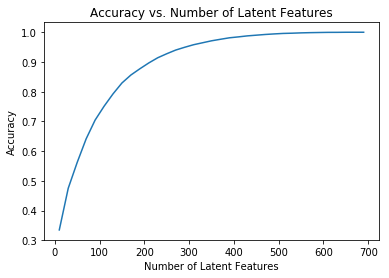

In [108]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

We need to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many movies can we make predictions for in the test set?  
* How many movies are we not able to make predictions for because of the cold start problem?

In [109]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)

    user_item_test = create_user_item_matrix(df_test)
    
    train_idx = set(user_item_train.index)
    test_idx = set(user_item_test.index)
    match_idx = list(train_idx.intersection(test_idx))
    
    train_arts = set(user_item_train.columns)
    test_arts =  set(user_item_test.columns)
    match_cols = list(train_arts.intersection(test_arts))

    user_item_test = user_item_test.loc[match_idx, match_cols]
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [111]:
make_user_predictions = len(list(set(df_train['user_id']).intersection(set(df_test['user_id']))))
print("we can make predictions for {} users".format(make_user_predictions))

print("We cannot make predictions for {} users".format(df_test['user_id'].nunique() - make_user_predictions))

make_article_predictions = len(list(set(df_train['article_id']).intersection(set(df_test['article_id']))))
print("we can make predictions for {} articles".format(make_article_predictions))
print("We cannot make predictions for {} articles".format(df_test['article_id'].nunique() - make_article_predictions))

we can make predictions for 20 users
We cannot make predictions for 662 users
we can make predictions for 574 articles
We cannot make predictions for 0 articles


`5.` Now we will use the **user_item_train** dataset from above to find **U**, **S**, and **V** transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that we can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. 

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [113]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(np.array(user_item_train, dtype='int')) # fit svd similar to above then use the cells below

#Identify the users in the test set that are also in the training
test_row_idx = user_item_train.index.isin(test_idx)
test_col_idx = user_item_train.columns.isin(test_arts)
u_test = u_train[test_row_idx,:]
v_test = vt_train[:,test_col_idx]


#user_item_train = np.matrix(user_item_train)
#user_item_test  = np.matrix(user_item_test)

num_latent_feats = np.arange(10,700+10,20)
train_sum_errs = []
test_sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    u_train_new, s_train_new, vt_train_new =  u_train[:, :k], np.diag(s_train[:k]), vt_train[:k,:]
    u_test_new, vt_test_new =  u_test[:, :k], v_test[:k,:]
    
    # take dot product
    train_preds = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    test_preds  = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # compute error for each prediction to actual value
    train_diffs = np.subtract(user_item_train, train_preds)
    test_diffs  = np.subtract(user_item_test, test_preds)
    
    # total errors and keep track of them
    train_err = np.sum(np.sum(np.abs(train_diffs)))
    train_sum_errs.append(train_err)
    test_err = np.sum(np.sum(np.abs(test_diffs)))
    test_sum_errs.append(test_err)

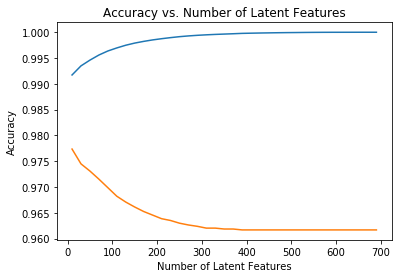

In [114]:
plt.plot(num_latent_feats, 1 - np.array(train_sum_errs)/(user_item_train.shape[0]* user_item_train.shape[1]));
plt.plot(num_latent_feats, 1 - np.array(test_sum_errs)/(user_item_test.shape[0]* user_item_test.shape[1]));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` **Conslusion**

Since there were only 20 individuals who co-existed between the training and testing datasets, there isn't exactly a lot data that can be used to test how well predictions via collaborative filtering with SVD are matching up with actual values.

Though the above plot makes it look like we are doing great in terms of accuracy.

We can use an Online approach where we can create user control groups. These control groups are divided into 3-4 categories: i.e. users without recommendations and Users with recommendations using different approaches.

We can create Hypothesis:

**Null Hypothesis:** There is no difference in user interactions using recommendation system.

**Alternate Hypothesis:** There is increase in user interactions after implementing the recommendations system.

we can then compare the results of user interactions with the articles and if there is significant change in the interaction then we can say recommendation system helped in increasing the user interaction.

**Same approach can be further taken to decide which recoomendation system works better.**

In [116]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0